Import the project library for glyph generation, classification, plotting, etc.

In [282]:
import littleglyphs as lilg
import littleglyphs.plotting as lilgplt
import littleglyphs.classification as lilgcls
import littleglyphs.examples as lilgex

import importlib
importlib.reload(lilg)
importlib.reload(lilgplt)
importlib.reload(lilgcls)
importlib.reload(lilgex)

<module 'littleglyphs.examples' from '/home/incide/projects/littleglyphs/littleglyphs/examples.py'>

Import prerequisite libraries.

In [283]:
import copy
import time

import numpy as np
import scipy
import skimage
import sklearn 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

random_seed = 456

np.random.seed(random_seed)

Generate a glyph _alphabet_ (an array of glyphs each belonging to a unique _category_). From it, making a set of glyphs with slightly different strokes (glyph _permutations_), produce images, then use a set of transformations (_distortions_) on those images to produce glyph _variations_.

In [284]:
N_glyphs_in_alphabet = 15

N_bezier_features = 0
N_line_features = 0
N_ellipse_features = 0
N_multipoint_line_features = 0
multipoint_line_feature_N_points = 3
N_multipoint_bezier_features = 1
multipoint_bezier_feature_N_points = 3


N_glyph_permutations = 20
permutation_strength = 0.05

imgsize = 16

N_glyph_raster_distortions = 30
rotat_distort_max = np.pi / 8
shear_distort_max = np.pi / 8
scale_distort_max = 0.25

blur_factor = 1

N_variations_per_glyph = N_glyph_permutations*N_glyph_raster_distortions

time_start = time.time()
print('Generating glyph alphabet and glyph variations... ', end='')

def makeRandomGlyph(category):
    glyph = lilg.Glyph(
        [lilg.FeatureBezierCurve() for count in range(0,N_bezier_features)]+
        [lilg.FeatureLineSegment() for count in range(0,N_line_features)]+
        [lilg.FeatureEllipse() for count in range(0,N_ellipse_features)]+
        [lilg.FeatureMultiPointLineSegment(multipoint_line_feature_N_points) for count in range(0,N_multipoint_line_features)]+
        [lilg.FeatureMultiPointBezierCurve(multipoint_bezier_feature_N_points) for count in range(0,N_multipoint_bezier_features)]
    )
    glyph.set_category(category)
    glyph.randomize_all_features()
    return glyph

glyphs = []
glyph_categories = list(range(0,N_glyphs_in_alphabet))

#for category in glyph_categories:
#    glyph = makeRandomGlyph(category)
#    glyphs.append(glyph)
    
starter_glyph = makeRandomGlyph(0)    
for category in glyph_categories:
    glyph = starter_glyph.permuted(permutation_strength)
    glyph.set_category(category)
    glyphs.append(glyph)

glyph_alphabet = lilg.GlyphList(glyphs)

#glyph_alphabet = lilg.examples.MNISTlike_glyph_alphabet()
#N_glyphs_in_alphabet = len(glyph_alphabet)

glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [
        lilg.DistortionRandomAffine(
            rotat_distort_max = rotat_distort_max, 
            shear_distort_max = shear_distort_max,
            scale_distort_max = scale_distort_max
        )
    ]
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)


time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')


Generating glyph alphabet and glyph variations... done in 11.365 sec (0.758 sec per glyph).


Visualise the glyphs and show some examples of glyph rasters.

Ground truth glyphs:


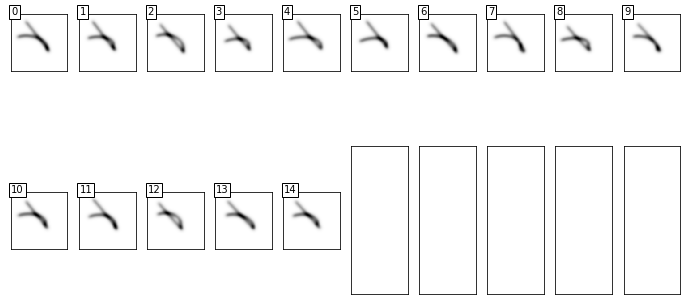

In [285]:
print('Ground truth glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = N_glyphs_in_alphabet, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

Examples of glyph images:


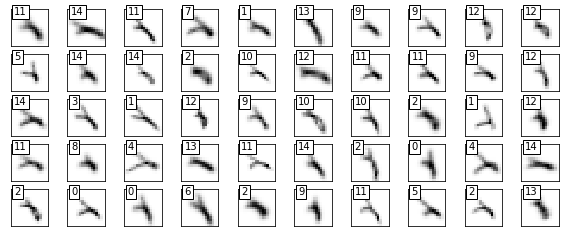

In [286]:
print('Examples of glyph images:')
N_images_to_show = 50

random_indices = np.arange(len(glyph_rasters))
np.random.shuffle(random_indices)
vis_imgs = glyph_rasters[random_indices[0:N_images_to_show]]
vis_categories = glyph_rasters.categories[random_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(10,4))
plt.show()

### Categorize the data using a CNN

Make a one-hot encoded category correspondence array for the glyph variations.

In [433]:
category_classes, inverse_category_class_indices = np.unique(glyph_rasters.categories, return_inverse=True)
N_classes = len(category_classes)

X = glyph_rasters.rasters
Y = keras.utils.to_categorical(glyph_rasters.categories, num_classes=N_classes)

We have our data ready to be fed to the categorizer. Split it into training, cross-validation, and test sets.

In [434]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = lilgcls.split_data_for_learning(
    X, Y, 
    crossval_proportion = 0.2, 
    test_proportion = 0.2, 
    random_seed=random_seed
)
    
print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (5400, 16, 16); Y_train matrix shape: (5400, 15)
X_test  matrix shape: (1800, 16, 16); Y_test  matrix shape: (1800, 15)
X_cv    matrix shape: (1800, 16, 16); Y_cv    matrix shape: (1800, 15)


Prepare a CNN model.

In [435]:
keras.backend.clear_session()
model = lilgcls.make_CNN_model(imgsize, N_classes, complexity = 4)

We have our model. Transform the data into a format that can be fed to it, and start training.

In [436]:
X_train_conv = lilgcls.prep_data_for_CNN_model(X_train, imgsize)
X_cv_conv = lilgcls.prep_data_for_CNN_model(X_cv, imgsize)

N_epochs = 10

#from keras.callbacks import ModelCheckpoint
#checkpoint_filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

h = model.fit(
    X_train_conv, Y_train, 
    epochs=N_epochs, batch_size=N_classes*10, 
    verbose=2,
    #callbacks=callbacks_list, 
    validation_data=(X_cv_conv,Y_cv)
)

#from IPython.display import Audio
#Audio('./bell.ogg',autoplay=True)

Train on 5400 samples, validate on 1800 samples
Epoch 1/10
 - 2s - loss: 2.6234 - acc: 0.1557 - val_loss: 2.4530 - val_acc: 0.2722
Epoch 2/10
 - 1s - loss: 2.2657 - acc: 0.2872 - val_loss: 1.8960 - val_acc: 0.5122
Epoch 3/10
 - 1s - loss: 1.9186 - acc: 0.3874 - val_loss: 1.5268 - val_acc: 0.6250
Epoch 4/10
 - 1s - loss: 1.7064 - acc: 0.4467 - val_loss: 1.2899 - val_acc: 0.6628
Epoch 5/10
 - 1s - loss: 1.5360 - acc: 0.4952 - val_loss: 1.1222 - val_acc: 0.7017
Epoch 6/10
 - 1s - loss: 1.3997 - acc: 0.5363 - val_loss: 0.9745 - val_acc: 0.7272
Epoch 7/10
 - 1s - loss: 1.3038 - acc: 0.5680 - val_loss: 0.8962 - val_acc: 0.7394
Epoch 8/10
 - 1s - loss: 1.2116 - acc: 0.5972 - val_loss: 0.7984 - val_acc: 0.7678
Epoch 9/10
 - 1s - loss: 1.1608 - acc: 0.6109 - val_loss: 0.7510 - val_acc: 0.7794
Epoch 10/10
 - 1s - loss: 1.0803 - acc: 0.6317 - val_loss: 0.6911 - val_acc: 0.7867


Show the evolution of training/cross-validation losses and accuracies.

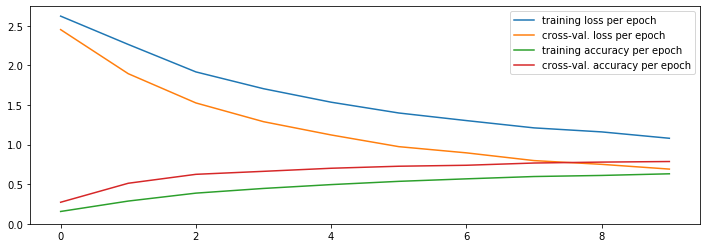

1800/1800 [==============================] - 0s 124us/step
Loss on test set: ~0.74
Accuracy on test set: ~78%


In [437]:
accurs = h.history['acc']
val_accurs = h.history['val_acc']
losses = h.history['loss']
val_losses = h.history['val_loss']
epoch_numbers = h.epoch

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
plt.plot(epoch_numbers, accurs, label='training accuracy per epoch')
plt.plot(epoch_numbers, val_accurs, label='cross-val. accuracy per epoch')
ax.set_ylim([0,None])
ax.legend()
plt.show()

X_test_conv = lilgcls.prep_data_for_CNN_model(X_test,imgsize)
loss_and_metrics = model.evaluate(X_test_conv, Y_test, batch_size=128)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

Evaluate the model's predictions for the test data.

In [438]:
Y_predicted = model.predict(X_test_conv, batch_size=128)
Y_predicted_class = np.argmax(Y_predicted, axis=1)
Y_predicted_probability = np.max(Y_predicted, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)

Visualise the examples of test data and predictions on test data.

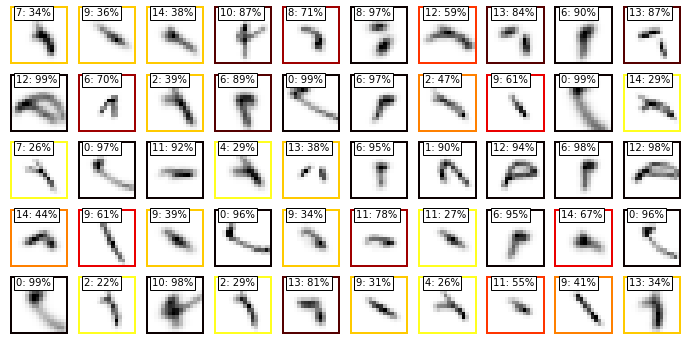

In [439]:
N_images_to_show = 50

vis_imgs = X_test[:N_images_to_show]
vis_categories = Y_predicted_class[:N_images_to_show]
vis_probabilities = Y_predicted_probability[:N_images_to_show]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap = 'hot_r', figsize=(12,6))
plt.show()

### Change the ambiguous glyphs

Calculate probabilistic confusion entropy matrix. 

The matrix is basically like a regular confusion matrix, but instead of discretely treating the highest output of the classifier as the output class, it smoothly treats all outputs of the classifier as "surety" of the classifier in each class. This uncovers information about the cases where the classifier works, but is not very sure in its answers.

Each row corresponds to the "true" class. Each column corresponds to the "surety" of the classifier in its output for the column. So, for instance, an element [4,2] corresponds to the average degree of surety with which the classifier says "it belongs to class 2" when it sees an element that in reality belongs to class 4.
Similarly to the case of a regular confusion matrix, a good classifier will have high values of diagonal elements and low values of all other elements.

( Based on doi:10.3390/e15114969 )


Probabilistic confusion entropy matrix:


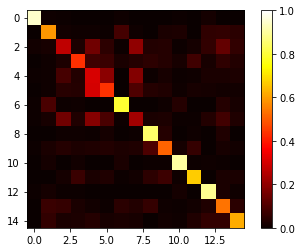

Class with worst performance: 7
Class with best performance:  0


In [440]:
prob_conf_ent_matrix = lilgcls.prob_conf_ent_matrix(Y_test,Y_predicted,N_classes)

worst_class_index = np.diagonal(prob_conf_ent_matrix).argmin()
best_class_index =  np.diagonal(prob_conf_ent_matrix).argmax()

print('Probabilistic confusion entropy matrix:')
#print(np.around(prob_conf_ent_matrix,decimals=3))
plt.imshow(prob_conf_ent_matrix, vmin=0, vmax=1, cmap='hot')
plt.colorbar()
plt.show()
print('Class with worst performance: '+str(worst_class_index))
print('Class with best performance:  '+str(best_class_index))


Show the worst confusion case.

In [441]:
prob_conf_ent_matrix_nodiag = prob_conf_ent_matrix.copy()
np.fill_diagonal(prob_conf_ent_matrix_nodiag,0)

worst_confusion_index = np.unravel_index(
    np.argmax(prob_conf_ent_matrix_nodiag, axis=None), 
    prob_conf_ent_matrix_nodiag.shape
)
print('Most confused pair: class '
      +str(worst_confusion_index[0])
      +' is being mistaken for class '
      +str(worst_confusion_index[1])
      +' with probability '
      +str(np.around(prob_conf_ent_matrix_nodiag[worst_confusion_index],decimals=3))
     )

Most confused pair: class 5 is being mistaken for class 4 with probability 0.301


Visualise examples of the glyphs corresponding to the worst encountered confusion.

Actual distribution of classes for test data:
[137 106 131 121 113 135 136 112 113 111 118 129  99 113 126]
Distribution of classes for test data as predicted by the classifier:
[139  99  92  90 139 129 152  75 141 122 125 128 110 106 153]
Examples of class 5:


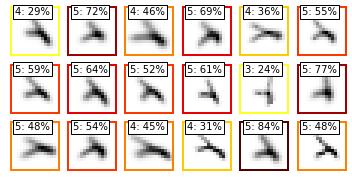

Examples of class 4:


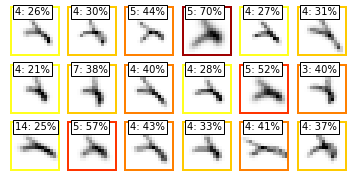

In [442]:
print('Actual distribution of classes for test data:')
print(np.bincount(Y_test_class))
print('Distribution of classes for test data as predicted by the classifier:')
print(np.bincount(Y_predicted_class))

N_images_to_show = 18

print('Examples of class '+str(worst_confusion_index[0])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[0])[0]
vis_indices = vis_indices[:N_images_to_show]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)                            
                            )
plt.show()

print('Examples of class '+str(worst_confusion_index[1])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[1])[0]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,                             
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)
                            )
plt.show()


Randomly generate glyphs until spotting a glyph that has a lot of _ambiguity for the current classifier_. An _ambiguous_ glyph is defined as one with which the classifier has trouble assigning it to any of the classes.

Note that selecting for ambiguity __does not necessarily__ select a glyph that is the most _dissimilar_ to the glyphs encountered by the classifier. For instance, a glyph that combines some elements of all glyphs in current alphabet would likely be quite ambiguous. So could be a glyph that doesn't look like any of the glyphs in current alphabet.

To define a metric for ambiguity, we can use the euclidean square distance of the probability matrix diagonal to the diagonal for the ideal ambiguous symbol. E.g. if we have two different symbols with an ideal classifier, the probability matrix would be: 
``` 
1 0
0 1
```
while two identical symbols (or a purely random classifier) would have a matrix of
```
0.5 0.5
0.5 0.5
```

So for a glyph that is classified as ```[0.8 0.2]``` the distance from ideal ambiguity would be (0.8-0.5)^2 + (0.2-0.5)^2 = ```0.18```, while for a glyph that is classified as ```[0.6 0.4]``` the distance would be (0.6-0.5)^2 + (0.4-0.5)^2 = ```0.02```.

In [443]:
best_ambiguity = N_classes # an impossibly high value for ambiguity distance
ideal_ambiguity_probability = np.ones(N_classes) * (1/N_classes)
worst_glyph_ambiguity = np.sum((prob_conf_ent_matrix[worst_class_index] - ideal_ambiguity_probability)**2)

new_candidate_glyph_ambiguity_threshold = worst_glyph_ambiguity / 10
new_candidate_glyph_ambiguity_maxiter = 20

print(
    'Worst glyph\'s distance from ideal ambiguity: '+
    str(np.around(worst_glyph_ambiguity, decimals=3))
)

print(
    'Generating new glyph to replace the glyph with worst performance (target ambiguity distance: '+
    str(np.around(new_candidate_glyph_ambiguity_threshold,decimals=3))+
    '):'
)

i = 0
while (
    (i < new_candidate_glyph_ambiguity_maxiter) and 
    (best_ambiguity > new_candidate_glyph_ambiguity_threshold)
):
    new_candidate_glyph = makeRandomGlyph(worst_class_index)
    
    new_glyph_perm_list = lilg.GlyphList([new_candidate_glyph])
    new_glyph_perm_list = new_glyph_perm_list.permuted(permutation_strength, N_glyph_permutations)

    new_glyph_rasters = new_glyph_perm_list.render(
        (imgsize,imgsize), 
        blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
    )
    
    new_glyph_rasters = new_glyph_rasters.distorted(distorter, N_glyph_raster_distortions)
    
    X_new = new_glyph_rasters.rasters
    X_new_conv = lilgcls.prep_data_for_CNN_model(X_new,imgsize)
    Y_new_predicted = model.predict(X_new_conv, batch_size=128)

    Y_new_mean_class_probability = Y_new_predicted.mean(axis=0)
    #print('Candidate for new glyph - average classification:')
    #print(np.around(Y_new_mean_class_probability, decimals=3))
    #print('Candidate for new glyph - square distance from ideal ambiguity:')    
    distance_from_ideal_ambiguity = (Y_new_mean_class_probability - ideal_ambiguity_probability)**2
    #print(np.around(distance_from_ideal_ambiguity, decimals=3))
    total_distance_from_ideal_ambiguity = np.sum(distance_from_ideal_ambiguity)
    #print('Total distance from ideal ambiguity: '+str(np.around(total_distance_from_ideal_ambiguity, decimals=3)))
    #print()
    
    if best_ambiguity>total_distance_from_ideal_ambiguity:
        best_ambiguity = total_distance_from_ideal_ambiguity
        best_new_candidate_glyph = copy.deepcopy(new_candidate_glyph)
        best_new_glyph_rasters = copy.deepcopy(new_glyph_rasters)
        
    print(
        '\rIteration ' + str(i) + ': '+
        'current distance from ideal ambiguity: '+
        str(np.around(total_distance_from_ideal_ambiguity, decimals=3))+
        '; best: '+
        str(np.around(best_ambiguity, decimals=3)),
        end=''
    )
    
    i = i + 1
    

new_candidate_glyph = best_new_candidate_glyph
new_glyph_rasters = best_new_glyph_rasters
print()
print(
    'Best candidate distance from ideal ambiguity: '+str(np.around(best_ambiguity, decimals=3))+
    ', found in '+str(i)+' iterations (max '+str(new_candidate_glyph_ambiguity_maxiter)+' iterations).'
)        

Worst glyph's distance from ideal ambiguity: 0.072
Generating new glyph to replace the glyph with worst performance (target ambiguity distance: 0.007):
Iteration 19: current distance from ideal ambiguity: 0.099; best: 0.043
Best candidate distance from ideal ambiguity: 0.043, found in 20 iterations (max 20 iterations).


Examples of new glyph images:


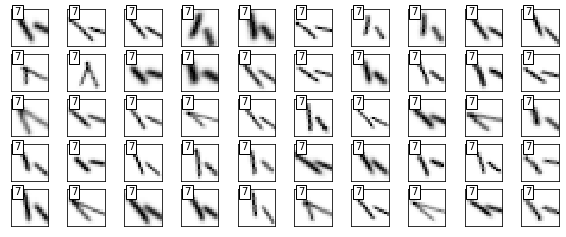

In [445]:
print('Examples of new glyph images:')
N_images_to_show = 50

random_indices = np.arange(len(new_glyph_rasters))
np.random.shuffle(random_indices)
vis_imgs = new_glyph_rasters[random_indices[0:N_images_to_show]]
vis_categories = new_glyph_rasters.categories[random_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(10,4))
plt.show()

# fig.savefig('./results/test.png',bbox_inches='tight')

Incorporate the new glyph in place of the old one. Generate a new set of rasters.

In [432]:
glyph_alphabet.remove_glyph_category(worst_class_index)
glyph_alphabet.add_glyph(new_candidate_glyph)

time_start = time.time()
print('Generating new glyph variations... ', end='')

glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)
   
time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')

Generating new glyph variations... done in 10.987 sec (0.732 sec per glyph).
